Computando os gradientes locais automaticamente
===============================================



## Introdução



Em um notebook anterior nós criamos uma classe chamada `Valor` que serviu de base para registrar o nosso `grafo computacional`. Este foi um passo importantíssimo para construirmos a nossa rede neural artificial.

Neste notebook nós vamos atualizar a classe `Valor` para que ela seja capaz de computar o gradiente local de cada vértice numérico do grafo computacional. Esse cálculo será feito &ldquo;de trás para frente&rdquo;, iniciando pelo vértice folha e retornando até os vértices raiz. O nome desse processo é `backpropagation` e é o coração do processo de treinar uma rede neural artificial.



## Importações



In [1]:
try:
    import graphviz
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install graphviz

In [2]:
from funcoes import plota_grafo

## Código e discussão



### Relembrando o que temos



No notebook anterior construímos a seguinte classe chamada `Valor`:



In [3]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo

    def __repr__(self):
        return f"Valor(data={self.data})"

    def __add__(self, outro_valor):
        data = self.data + outro_valor.data
        progenitor = (self, outro_valor)
        operador_mae = "+"
        saida = Valor(data, progenitor, operador_mae)
        return saida

    def __mul__(self, outro_valor):
        data = self.data * outro_valor.data
        progenitor = (self, outro_valor)
        operador_mae = "*"
        saida = Valor(data, progenitor, operador_mae)
        return saida

Com essa classe nós conseguimos plotar o grafo computacional que criamos na primeira aula sobre redes neurais artificiais usando a função `plota_grafo` criada por Andrej. Esse grafo computacional representa uma rede neural que nós criamos para prever o valor $y$.



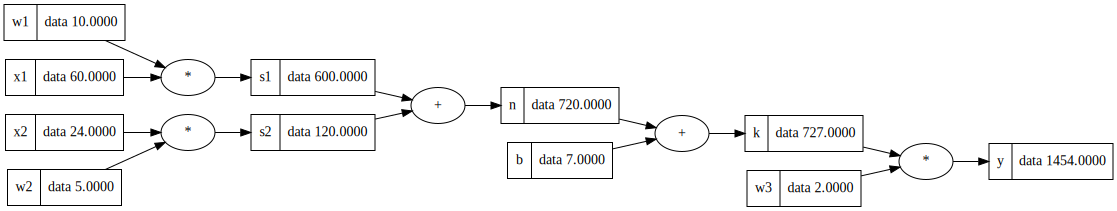

In [4]:
x1 = Valor(60, rotulo="x1")
x2 = Valor(24, rotulo="x2")
w1 = Valor(10, rotulo="w1")
w2 = Valor(5, rotulo="w2")
w3 = Valor(2, rotulo="w3")
b = Valor(7, rotulo="b")

s1 = x1 * w1
s1.rotulo = "s1"

s2 = x2 * w2
s2.rotulo = "s2"

n = s1 + s2
n.rotulo = "n"

k = n + b
k.rotulo = "k"

y = k * w3
y.rotulo = "y"

plota_grafo(y)

### Preparando o terreno para o cálculo do gradiente local



Cada valor numérico do grafo computacional deve ter um valor de `gradiente local` associado a ele. O gradiente local representa a derivada parcial do vértice final do grafo computacional (que é $y$ no nosso caso, também conhecido como vértice folha) em relação a o valor do vértice em questão.

Suponha que nosso vértice folha se chame $y$. Agora suponha que nós temos um vértice qualquer no nosso grafo computacional que se chama $w_2$. O gradiente local de $w_2$ nada mais é do que:

$$
\frac{\partial y}{\partial w_2}
$$

Se cada valor tem um gradiente local, então precisamos registrar isso na nossa classe. Vamos criar uma propriedade chamada `grad`. Vamos dar o valor padrão de zero para essa propriedade. Na próxima seção iremos alterar esse valor.



In [5]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"

    def __add__(self, outro_valor):
        data = self.data + outro_valor.data
        progenitor = (self, outro_valor)
        operador_mae = "+"
        saida = Valor(data, progenitor, operador_mae)
        return saida

    def __mul__(self, outro_valor):
        data = self.data * outro_valor.data
        progenitor = (self, outro_valor)
        operador_mae = "*"
        saida = Valor(data, progenitor, operador_mae)
        return saida

Com essa alteração, agora o grafo computacional mostra o gradiente! Mas o valor do gradiente ainda está errado&#x2026;



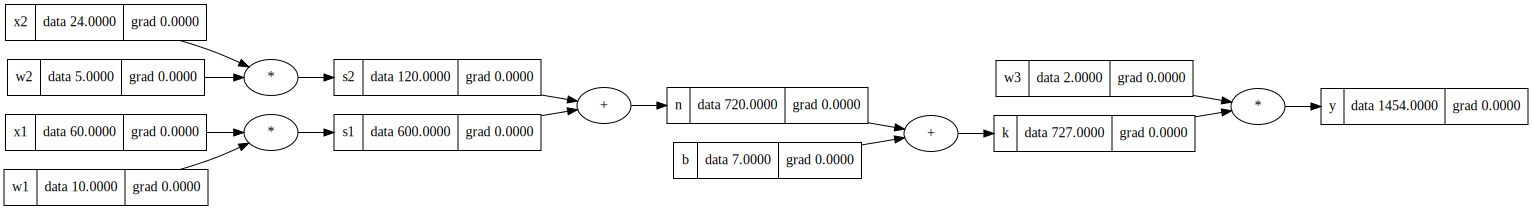

In [6]:
x1 = Valor(60, rotulo="x1")
x2 = Valor(24, rotulo="x2")
w1 = Valor(10, rotulo="w1")
w2 = Valor(5, rotulo="w2")
w3 = Valor(2, rotulo="w3")
b = Valor(7, rotulo="b")

s1 = x1 * w1
s1.rotulo = "s1"

s2 = x2 * w2
s2.rotulo = "s2"

n = s1 + s2
n.rotulo = "n"

k = n + b
k.rotulo = "k"

y = k * w3
y.rotulo = "y"

plota_grafo(y)

### Calculando o gradiente local &ldquo;na mão&rdquo;



Vamos relembrar o cálculo do gradiente local e calcular os gradientes na mão! Para isso usaremos de noções básicas de derivada e da regra da cadeia.



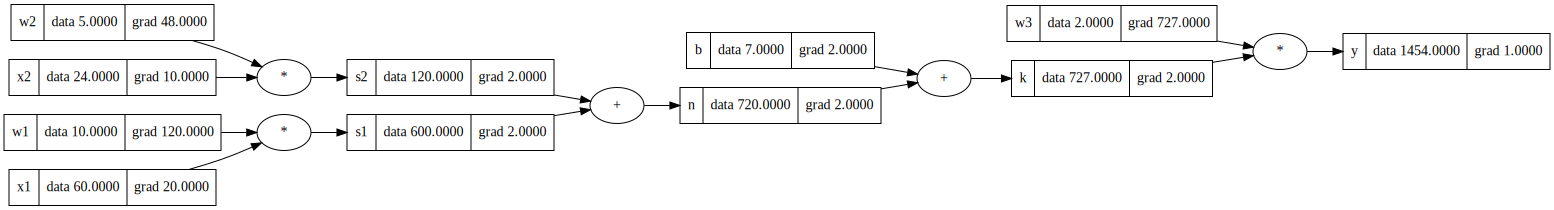

In [7]:
x1 = Valor(60, rotulo="x1")
x2 = Valor(24, rotulo="x2")
w1 = Valor(10, rotulo="w1")
w2 = Valor(5, rotulo="w2")
w3 = Valor(2, rotulo="w3")
b = Valor(7, rotulo="b")

s1 = x1 * w1
s1.rotulo = "s1"

s2 = x2 * w2
s2.rotulo = "s2"

n = s1 + s2
n.rotulo = "n"

k = n + b
k.rotulo = "k"

y = k * w3
y.rotulo = "y"

y.grad =  1

w3.grad =  y.grad * k.data # dy/dw3
k.grad =   y.grad * w3.data # dy/dk

b.grad = k.grad * 1 # dy/db = dy/dk * dk/db --> derivada de k em relação a b, sendo k= n + b, é 1
n.grad = k.grad * 1 # dy/dn = dy/dk * dk/dn --> derivada de k em relação a b, sendo k= n + b, é 1. Some é distribuidor de gradiente!

s2.grad = n.grad * 1 # dy/ds2 = dy/dn * dn/s2
s1.grad = n.grad * 1# dy/ds1 = dy/dn * dn/s1

x2.grad = s2.grad * w2.data  # dy/dx2 = dy/ds2 * ds2/dx2
w2.grad = s2.grad * x2.data # dy/dw2 = dy/ds2 * ds2/dw2

x1.grad =  s1.grad * w1.data # dy/dx1 = dy/ds1 * ds1/dx1
w1.grad =  s1.grad * x1.data # dy/dw1 = dy/ds1 * ds1/dw1

plota_grafo(y)

### Treinando uma rede neural &ldquo;na mão&rdquo;



Agora que temos um grafo computacional com todos os gradientes locais calculados, podemos treinar a nossa rede neural manualmente.

Suponha, por um momento, que eu queira aumentar o valor de $y$ de saída da minha rede neural. Tem duas coisas que eu sei:

1.  eu posso apenas alterar os parâmetros internos da minha rede neural, isto é: $w_1$, $w_2$, $w_3$ e $b$. Os demais parâmetros eu não posso alterar pois ou são dados de entrada ($x_1$ e $x_2$) ou são parâmetros derivados de outros parâmetros ($k$, $n$, $s_1$, $s_2$ e $y$).

2.  o gradiente local indica o &ldquo;impacto&rdquo; que teremos no valor de $y$. Um gradiente local positivo me indica que ao aumentar o respectivo valor do vértice eu aumento o valor de $y$. Um gradiente local negativo me indica que ao aumentar o respectivo valor do vértice eu diminuo o valor de $y$.

Sabendo destes dois fatos, como que eu posso aumentar o valor de saída de $y$ apenas alterando os parâmetros internos da minha rede neural?



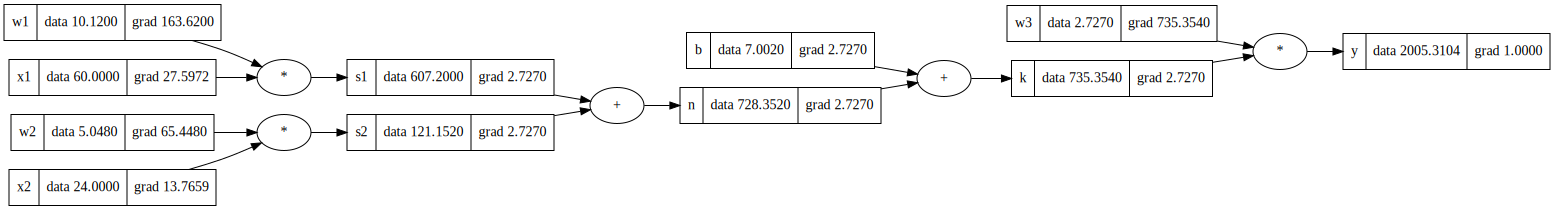

In [8]:
# as somas serão baseadas no gradiente

taxa_de_aprendizado= 0.001 # pegar só uma fração do gradiente

w1.data = w1.data + w1.grad * taxa_de_aprendizado
w2.data = w2.data + w2.grad * taxa_de_aprendizado
w3.data = w3.data + w3.grad * taxa_de_aprendizado
b.data = b.data + b.grad * taxa_de_aprendizado

s1 = x1 * w1
s1.rotulo = "s1"

s2 = x2 * w2
s2.rotulo = "s2"

n = s1 + s2
n.rotulo = "n"

k = n + b
k.rotulo = "k"

y = k * w3
y.rotulo = "y"

y.grad= 1
w3.grad =  y.grad * k.data # dy/dw3
k.grad =   y.grad * w3.data # dy/dk

b.grad = k.grad * 1 # dy/db = dy/dk * dk/db --> derivada de k em relação a b, sendo k= n + b, é 1
n.grad = k.grad * 1 # dy/dn = dy/dk * dk/dn --> derivada de k em relação a b, sendo k= n + b, é 1. Some é distribuidor de gradiente!

s2.grad = n.grad * 1 # dy/ds2 = dy/dn * dn/s2
s1.grad = n.grad * 1# dy/ds1 = dy/dn * dn/s1

x2.grad = s2.grad * w2.data  # dy/dx2 = dy/ds2 * ds2/dx2
w2.grad = s2.grad * x2.data # dy/dw2 = dy/ds2 * ds2/dw2

x1.grad =  s1.grad * w1.data # dy/dx1 = dy/ds1 * ds1/dx1
w1.grad =  s1.grad * x1.data # dy/dw1 = dy/ds1 * ds1/dw1

plota_grafo(y)

### Cálculo automático do gradiente local



Calcular o gradiente local &ldquo;na mão&rdquo; não é a tarefa mais rápida nem a mais prazerosa que existe. Você certamente consegue pensar em uma, quem sabe até duas tarefas mais rápidas e prazerosas que essa. Tendo observado isso, pessoas refletiram se não seria possível de realizar esse cálculo de maneira automática para sobrar mais tempo na vida para se dedicar a outras tarefas. *Spoiler*: é possível!

Nossa classe `Valor` agora terá um método chamado `propagar`. Esse método irá, como o nome sugere, propagar o gradiente local de um certo vértice para seus progenitores.

Como padrão, o método `propagar` não irá fazer nada. Isso será o caso de vértices raiz que não têm progenitores (se não tem progenitor, então não tem o que propagar!).

Quando um vértice tem progenitores, daí teremos que sobrescrever o método `propagar` para que ele efetivamente propague os gradientes seguindo a regra da cadeia. Vamos fazer isso nos métodos `__add__` e `__mul__`.



In [9]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"

    def __add__(self, outro_valor):
        data = self.data + outro_valor.data
        progenitor = (self, outro_valor)
        operador_mae = "+"
        saida = Valor(data, progenitor, operador_mae)

        def propagar_adicao():
            self.grad = saida.grad * 1
            outro_valor.grad = saida.grad * 1

        saida.propagar = propagar_adicao

        return saida

    def __mul__(self, outro_valor):
        data = self.data * outro_valor.data
        progenitor = (self, outro_valor)
        operador_mae = "*"
        saida = Valor(data, progenitor, operador_mae)

        def propagar_multiplicacao():
            self.grad = saida.grad * outro_valor.data
            outro_valor.grad = saida.grad * self.data

        saida.propagar = propagar_multiplicacao

        return saida

    def propagar(self):
        pass

Vamos testar!!



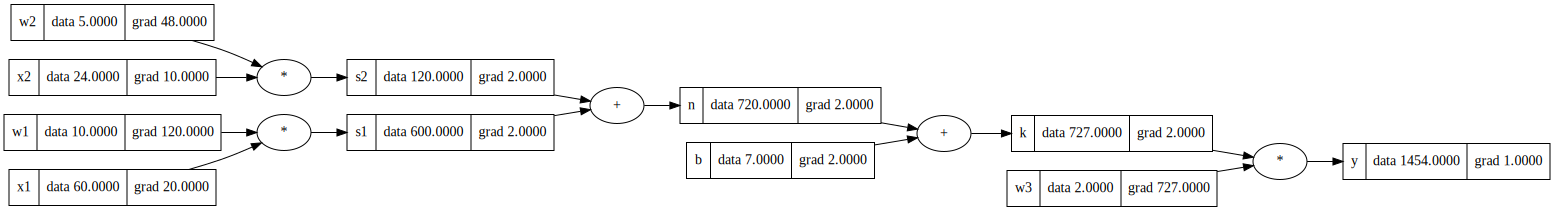

In [10]:
x1 = Valor(60, rotulo="x1")
x2 = Valor(24, rotulo="x2")
w1 = Valor(10, rotulo="w1")
w2 = Valor(5, rotulo="w2")
w3 = Valor(2, rotulo="w3")
b = Valor(7, rotulo="b")

s1 = x1 * w1
s1.rotulo = "s1"

s2 = x2 * w2
s2.rotulo = "s2"

n = s1 + s2
n.rotulo = "n"

k = n + b
k.rotulo = "k"

y = k * w3
y.rotulo = "y"

y.grad = 1  # precisamos iniciar o gradiente do vértice folha "na mão"
y.propagar()
k.propagar()
w3.propagar()
n.propagar()
b.propagar()
s1.propagar()
s2.propagar()
x1.propagar()
w1.propagar()
x2.propagar()
w2.propagar()

plota_grafo(y)

### Autograd



Temos, finalmente, todas as ferramentas para executar o que tanto queríamos: o algoritmo `backpropagation`. Para isso, nós tivemos que rodar o método `propagar` para todos os vértices do nosso grafo computacional. Seria tão mais interessante se esse processo todo fosse ainda mais automático!

Como você deve imaginar, podemos sim deixar esse processo ainda mais automático. Trata-se do algoritmo `autograd`! O último passo aqui é criar um método chamado `propagar_tudo` que cuida de fazer isso para nós.

O único detalhe que temos que nos atentar é que não podemos rodar o método `propagar` em qualquer ordem dos vértices do grafo computacional. Apenas podemos rodar esse método quando sabemos o gradiente local do vértice que irá propagar! Uma estratégia para nos ajudar aqui é fazer uma [ordenação topológica](https://en.wikipedia.org/wiki/Topological_sorting). Ordenação topológica é quando você ordena os vértices de um grafo direcional de forma que todas as setas apontem para a direita. Nota: não podemos realizar ordenação topológica em grafos cíclicos. Aqui usaremos o código pronto feito pelo Andrej Karpathy que resolve esse problema. Veja abaixo de forma gráfica como funciona a ordenação topológica.

![img](https://i.imgur.com/Q3MA6dZ.png)



In [11]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"

    def __add__(self, outro_valor):
        data = self.data + outro_valor.data
        progenitor = (self, outro_valor)
        operador_mae = "+"
        saida = Valor(data, progenitor, operador_mae)

        def propagar():
            self.grad = saida.grad * 1
            outro_valor.grad = saida.grad * 1

        saida.propagar = propagar

        return saida

    def __mul__(self, outro_valor):
        data = self.data * outro_valor.data
        progenitor = (self, outro_valor)
        operador_mae = "*"
        saida = Valor(data, progenitor, operador_mae)

        def propagar():
            self.grad = saida.grad * outro_valor.data
            outro_valor.grad = saida.grad * self.data

        saida.propagar = propagar

        return saida

    def propagar(self):
        pass

    def propagar_tudo(self):
        ordem_topologica = []
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)

        self.grad = 1  # o gradiente do vértice folha deve ser 1

        for v in reversed(ordem_topologica):
            v.propagar()

Finalmente, depois de uma longa jornada, chegamos no nosso objetivo!



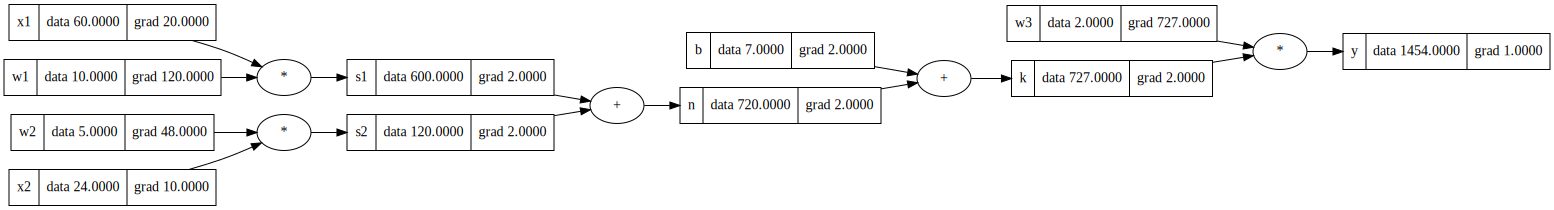

In [12]:
x1 = Valor(60, rotulo="x1")
x2 = Valor(24, rotulo="x2")
w1 = Valor(10, rotulo="w1")
w2 = Valor(5, rotulo="w2")
w3 = Valor(2, rotulo="w3")
b = Valor(7, rotulo="b")

s1 = x1 * w1
s1.rotulo = "s1"

s2 = x2 * w2
s2.rotulo = "s2"

n = s1 + s2
n.rotulo = "n"

k = n + b
k.rotulo = "k"

y = k * w3
y.rotulo = "y"

y.propagar_tudo()

plota_grafo(y)

### Correção final para gradientes locais de funções de várias variáveis



Existe um problema com o cálculo do gradiente local da forma que estamos fazendo. Este bug aparece quando um mesmo vértice é usado para mais de uma operação no grafo computacional. Observe a situação abaixo. O gradiente local de $a$ deveria ser 4, porém o grafo mostra como sendo 1. Isto acontece pois a regra da cadeia para funções de várias variáveis nos diz que devemos somar os gradientes do vértice cada vez que chegamos nele mesmo, porém o nosso código não reflete isso. Isso não era um problema antes pois não estávamos usando o valor de um vértice duas ou mais vezes no grafo computacional.



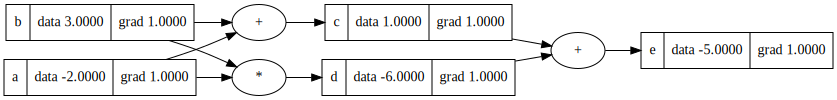

In [13]:
a = Valor(-2, rotulo="a")
b = Valor(3, rotulo="b")

c = a + b
d = a * b

e = c + d

c.rotulo = "c"
d.rotulo = "d"
e.rotulo = "e"

e.propagar_tudo()
plota_grafo(e)

Para a nossa sorte, é fácil de corrigir isso! Basta somar o gradiente com ele mesmo cada vez que ele for atualizado.



In [14]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"

    def __add__(self, outro_valor):
        data = self.data + outro_valor.data
        progenitor = (self, outro_valor)
        operador_mae = "+"
        saida = Valor(data, progenitor, operador_mae)

        def propagar():
            self.grad += saida.grad * 1
            outro_valor.grad += saida.grad * 1

        saida.propagar = propagar

        return saida

    def __mul__(self, outro_valor):
        data = self.data * outro_valor.data
        progenitor = (self, outro_valor)
        operador_mae = "*"
        saida = Valor(data, progenitor, operador_mae)

        def propagar():
            self.grad += saida.grad * outro_valor.data
            outro_valor.grad += saida.grad * self.data

        saida.propagar = propagar

        return saida

    def propagar(self):
        pass

    def propagar_tudo(self):
        ordem_topologica = []
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)

        self.grad = 1  # o gradiente do vértice folha deve ser 1

        for v in reversed(ordem_topologica):
            v.propagar()

Com isso corrigimos esse bug!



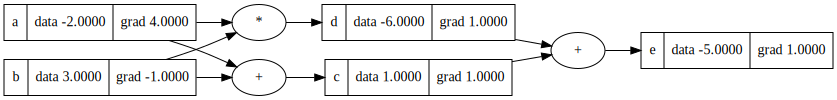

In [15]:
a = Valor(-2, rotulo="a")
b = Valor(3, rotulo="b")

c = a + b
d = a * b

e = c + d

c.rotulo = "c"
d.rotulo = "d"
e.rotulo = "e"

e.propagar_tudo()
plota_grafo(e)

## Conclusão



Nessa aula, basicamente usamos a estrutura de classes para elaborar um código que realiza o backpropagation automaticamente, e, para melhor visualização do que ocorre no código, plotamos um grafo da rede neural desenvolvida.

Para tanto, nós inicialmente relembramos alguns conceitos vistos na primeira aula, incluindo o próprio conceito de `backpropagation`, por meio do qual calculamos os `gradientes do parâmetro`. O método de backpropagation é dividido em duas fases:
- Fase Foward: a entrada é propagada pela rede até que se obtenha uma saída
- Fase backward:  erro da saída é propagado de volta pela rede para atualizar os pesos e bias de todas as camadas, utilizando o gradiente da função de erro em relação a cada peso.

Esse gradiente é calculado por meio da utilização de derivadas parciais, que são resolvidas pela regra da cadeia, assim como mostrado na figura abaixo.



<center>
  <img src='./Figuras/grafo_4.png' style="width:1200px;height:500px"/>
    
    Figura 1: grafo do método backpropagation
</center>

Basicamente, todo gradiente de parâmetro pode ser calculado por: gradiente do filho (variação de y em relação ao seu filho) * gradiente local do parâmetro (variação do seu filho em relação a ele mesmo)

Como consequência, temos dois tipos de cálculo de gradiente:

* Progenitores que geram filhos por meio da operação de soma: o gradiente pode ser calculado por: **gradiente do filho * 1 (que é o valor do seu gardiente local)**
* Progenitores que geram filhos por meio da operação de multiplicação: o gradiente pode ser calculado por: **gradiente do filho * outro progenitor (que é o valor do seu gardiente local)**

Logo, para calcular o backpropagation de maneira automática, bastou incorporar esses dois tipos de cálculo à nossa classe. Isso foi feito adicionando novas propriedades à classe, incluindo o método dunder `__mult__`, para multiplicar vérticies, a instância `grad`, para calcular armazenar o valor dos gradientes, o método `propagar` que calcula o valor dos gradientes, e o método `propagar_tudo`, para o cálculo automático. Além disso, para o cálculo dos gradientes, foi necessário fazer ordenação topológica.

## Playground

